In [ ]:
import pandas as pd
from IPython.display import display
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.preprocessing import OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.model_selection import train_test_split, cross_validate, GridSearchCV
from sklearn.pipeline import Pipeline
from sklearn.metrics import classification_report, confusion_matrix
from sklearn import tree

from sklearn.tree import DecisionTreeClassifier


In [ ]:
data = pd.read_csv("https://raw.githubusercontent.com/NUS-BACT/datasets/master/Heart_Disease_Prediction.csv")

data

,Age,Sex,Chest pain type,BP,Cholesterol,FBS over 120,EKG results,Max HR,Exercise angina,ST depression,Slope of ST,Number of vessels fluro,Thallium,Heart Disease
0,70,1,4,130,322,0,2,109,0,2.4,2,3,3,Presence
1,67,0,3,115,564,0,2,160,0,1.6,2,0,7,Absence
2,57,1,2,124,261,0,0,141,0,0.3,1,0,7,Presence
3,64,1,4,128,263,0,0,105,1,0.2,2,1,7,Absence
4,74,0,2,120,269,0,2,121,1,0.2,1,1,3,Absence
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
265,52,1,3,172,199,1,0,162,0,0.5,1,0,7,Absence
266,44,1,2,120,263,0,0,173,0,0.0,1,0,7,Absence
267,56,0,2,140,294,0,2,153,0,1.3,2,0,3,Absence
268,57,1,4,140,192,0,0,148,0,0.4,2,0,6,Absence


In [ ]:
data.isna().sum()

Age                        0
Sex                        0
Chest pain type            0
BP                         0
Cholesterol                0
FBS over 120               0
EKG results                0
Max HR                     0
Exercise angina            0
ST depression              0
Slope of ST                0
Number of vessels fluro    0
Thallium                   0
Heart Disease              0
dtype: int64

# Data Pre-Processing

In [ ]:
data_clean = data.copy()

# Train-test split
X = data_clean.drop(columns=["Heart Disease"])
y = data_clean["Heart Disease"]
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Decision Tree

In [ ]:
# get list of all categorical variables
categorical_variables = []

categorical_variables.extend(["Sex", "Chest pain type", "FBS over 120", "EKG results", "Exercise angina", "Slope of ST", "Thallium"])
print("Categorical variables: ", categorical_variables)

# One-hot encoding without dropping first
enc_tree = OneHotEncoder(sparse=False, handle_unknown="ignore")

transformer_tree = ColumnTransformer([
    ("categorical", enc_tree, categorical_variables)
], remainder="passthrough")

pipeline_dt = Pipeline([("transformer", transformer_tree), ("decision_tree", DecisionTreeClassifier())])

Categorical variables:  ['Sex', 'Chest pain type', 'FBS over 120', 'EKG results', 'Exercise angina', 'Slope of ST', 'Thallium']


In [ ]:
# Cross validate

def show_cv_results(pipeline):
  scores = cross_validate(pipeline, X_train, y_train, cv=10, return_train_score=True) 
  print("Mean test score:", scores["test_score"].mean())
  display(pd.DataFrame(scores))

show_cv_results(pipeline_dt)

Mean test score: 0.727056277056277


,fit_time,score_time,test_score,train_score
0,0.010268,0.004470,0.727273,1.0
1,0.006287,0.003610,0.545455,1.0
2,0.005783,0.003151,0.636364,1.0
3,0.005390,0.003206,0.636364,1.0
4,0.005306,0.003249,0.818182,1.0
5,0.005670,0.003711,0.954545,1.0
6,0.004915,0.002788,0.761905,1.0
7,0.004746,0.002891,0.904762,1.0
8,0.004977,0.002785,0.761905,1.0
9,0.004762,0.002686,0.523810,1.0


In [ ]:
grid_dt = {
    "decision_tree__max_depth": [5, 50, 75, 100]
}

gs_dt = GridSearchCV(pipeline_dt, grid_dt)
gs_dt.fit(X_train, y_train)

# helper function to view grid search results

def report_GridSearchCV_results(gs):
    print("Best combination of hyperparams:\n", gs.best_params_, "\n")
    print("Best mean_test_score score:\n", gs.best_score_, "\n")
    
    scores = []
    for i in range(gs.n_splits_):
        scores.append(gs.cv_results_['split{}_test_score'.format(i)][gs.best_index_])
    print("Score by fold for best estimator:\n", scores, "\n")
    
    # View top 5 hyperparams combinations by mean_test_score (mean on "validation" set)
    print("Top 5 hyperparams combinations by mean_test_score:")
    display(pd.DataFrame(gs.cv_results_)[["rank_test_score", "mean_test_score"] 
                                            + ["param_" + param for param in gs.param_grid]]\
              .sort_values(by = "mean_test_score", ascending = False)\
              .set_index("rank_test_score").head(5))

report_GridSearchCV_results(gs_dt)

Best combination of hyperparams:
 {'decision_tree__max_depth': 100} 

Best mean_test_score score:
 0.7173361522198732 

Score by fold for best estimator:
 [0.7727272727272727, 0.6976744186046512, 0.813953488372093, 0.6511627906976745, 0.6511627906976745] 

Top 5 hyperparams combinations by mean_test_score:


,mean_test_score,param_decision_tree__max_depth
rank_test_score,,
1,0.717336,100
2,0.699154,50
3,0.694397,75
4,0.689852,5


In [ ]:
grid2_dt = {
    "decision_tree__max_depth": range(50, 100)
}

gs2_dt = GridSearchCV(pipeline_dt, grid2_dt)
gs2_dt.fit(X_train, y_train)

# helper function to view grid search results

def report_GridSearchCV_results(gs):
    print("Best combination of hyperparams:\n", gs.best_params_, "\n")
    print("Best mean_test_score score:\n", gs.best_score_, "\n")
    
    scores = []
    for i in range(gs.n_splits_):
        scores.append(gs.cv_results_['split{}_test_score'.format(i)][gs.best_index_])
    print("Score by fold for best estimator:\n", scores, "\n")
    
    # View top 5 hyperparams combinations by mean_test_score (mean on "validation" set)
    print("Top 5 hyperparams combinations by mean_test_score:")
    display(pd.DataFrame(gs.cv_results_)[["rank_test_score", "mean_test_score"] 
                                            + ["param_" + param for param in gs.param_grid]]\
              .sort_values(by = "mean_test_score", ascending = False)\
              .set_index("rank_test_score").head(5))
    
report_GridSearchCV_results(gs2_dt)

Best combination of hyperparams:
 {'decision_tree__max_depth': 93} 

Best mean_test_score score:
 0.7267441860465117 

Score by fold for best estimator:
 [0.75, 0.6976744186046512, 0.813953488372093, 0.6511627906976745, 0.7209302325581395] 

Top 5 hyperparams combinations by mean_test_score:


,mean_test_score,param_decision_tree__max_depth
rank_test_score,,
1,0.726744,93
2,0.722199,71
3,0.713108,87
4,0.712791,59
5,0.708457,67


              precision    recall  f1-score   support

     Absence       0.82      0.70      0.75        33
    Presence       0.62      0.76      0.68        21

    accuracy                           0.72        54
   macro avg       0.72      0.73      0.72        54
weighted avg       0.74      0.72      0.73        54



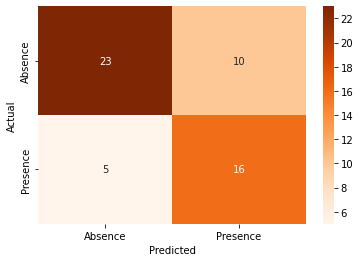

In [ ]:
# Performance on the test set

def score_model(model, x, y):
    pred = model.predict(x)
    print(classification_report(y, pred, zero_division))

    cm = confusion_matrix(y, pred)
    columns = np.unique(y)
    df_cm = pd.DataFrame(cm, index=columns, columns=columns)
    ax = sns.heatmap(df_cm, cmap='Oranges', annot=True, fmt='g')
    ax.set_xlabel("Predicted")
    ax.set_ylabel("Actual")
    
score_model(gs2_dt, X_test, y_test)

In [ ]:
# helper function to plot tree

def plot_tree(model, X):

    fig = plt.figure(figsize=(25,20), dpi=300)
    tree.plot_tree(model, feature_names = X.columns,  
               filled = True, 
               proportion= True,
               # added class_names for clearer prediction
               class_names= model.classes_)
    
# helper function to get feature importance    
def plot_importance(model, X):

    importances = pd.Series(data=model.feature_importances_,
                            index= list(X.columns))
    
    importances_sorted = importances.sort_values()
    
    importances_sorted = importances_sorted[-10:]

    plt.figure(figsize = (10, 6))
    importances_sorted.plot(kind='barh', color='blue')
    plt.title('Top 10 Feature Importance')
    plt.xlabel("Importance")
    plt.show()

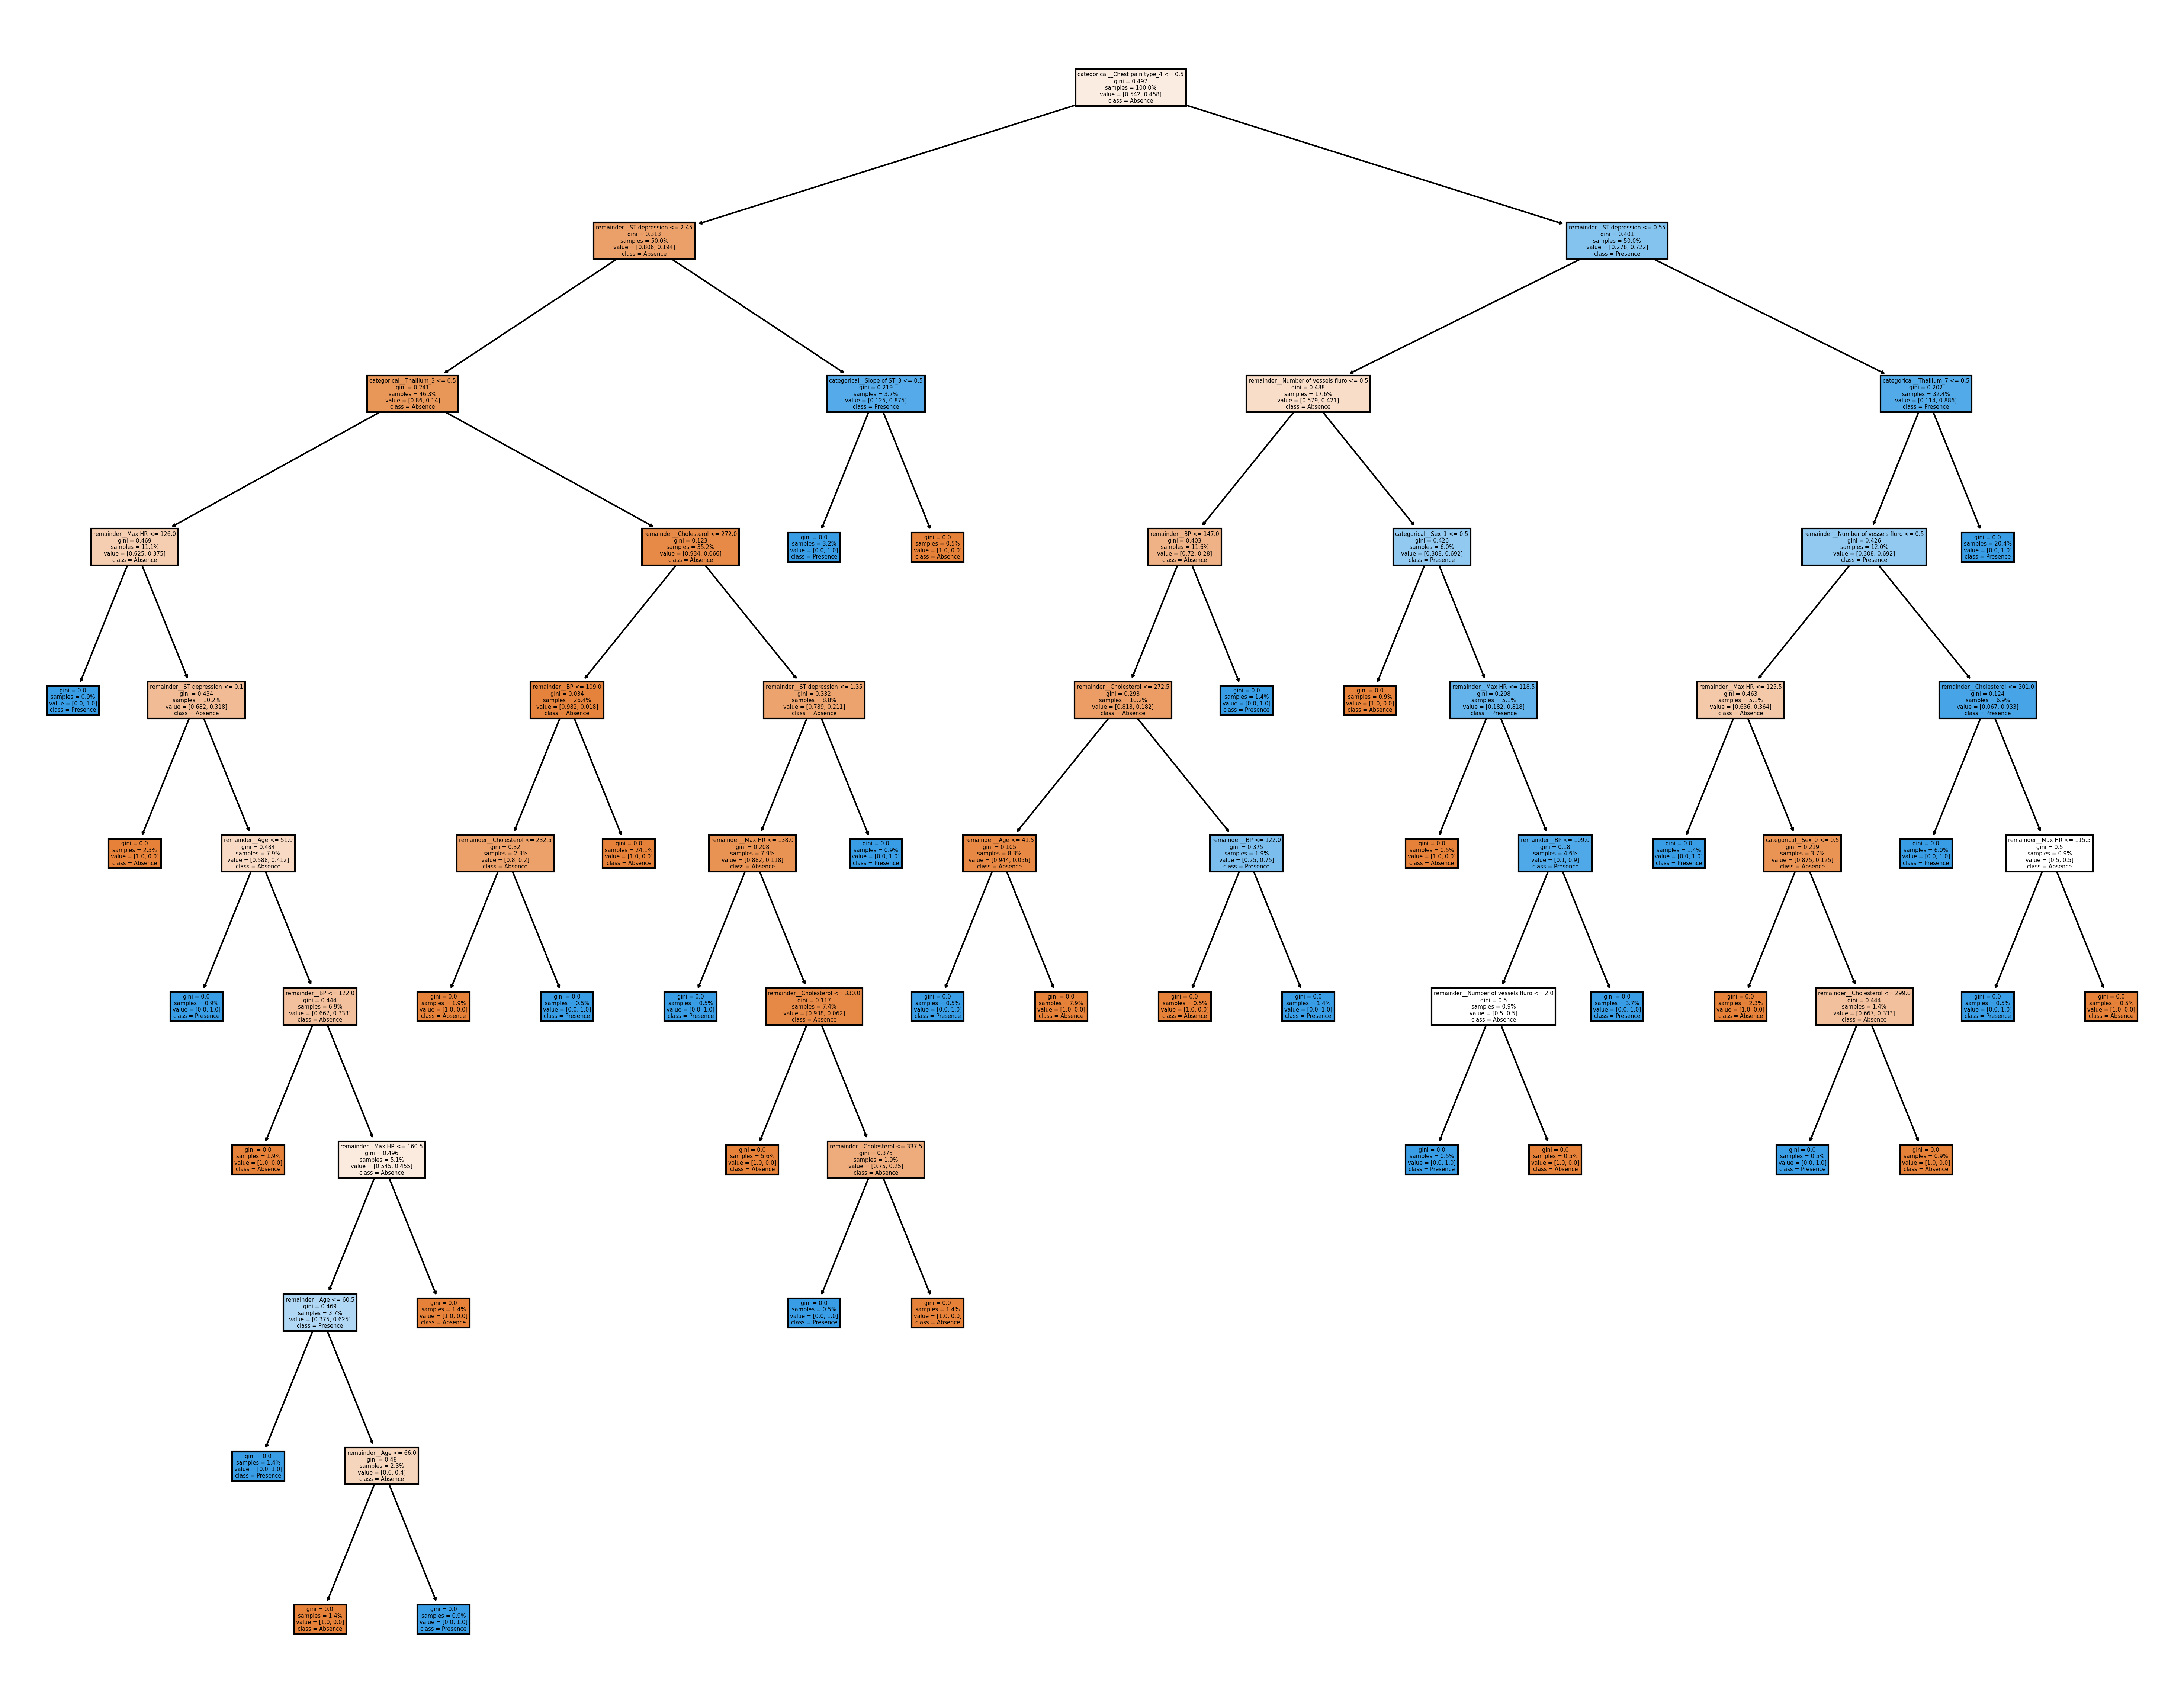

In [ ]:
X_train_encoded_tree = pd.DataFrame(transformer_tree.fit_transform(X_train), columns=transformer_tree.get_feature_names_out())

plot_tree(gs2_dt.best_estimator_.named_steps["decision_tree"], X_train_encoded_tree)

plt.savefig('tree.eps',format='eps',bbox_inches = "tight")

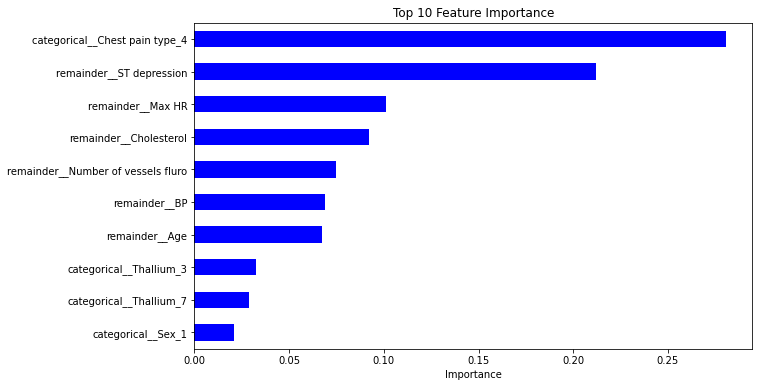

In [ ]:
plot_importance(gs2_dt.best_estimator_.named_steps["decision_tree"], X_train_encoded_tree)